# MNIST QNN Classifier using PennyLane

## Import Libraries

In [1]:
import pennylane as qml
from pennylane import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
print(qml.__version__)
print(torch.__version__)

0.36.0
2.2.1+cu121


## Data Loading and preprocessing

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((4, 4)),
                                transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:03<00:00, 3234035.15it/s]


Extracting ../data\MNIST\raw\train-images-idx3-ubyte.gz to ../data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 44803.89it/s]


Extracting ../data\MNIST\raw\train-labels-idx1-ubyte.gz to ../data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:03<00:00, 468425.73it/s]


Extracting ../data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2277953.94it/s]

Extracting ../data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\MNIST\raw



## Define a Quantum Device
We will use PennyLane to define a quantum device. For simplicity, we'll use the default qubit device with 16 qubits (4x4 image).

In [6]:
n_qubits = 16
dev = qml.device("default.qubit", wires=n_qubits)

## Define a QNN Model

A QNN is a neural network that includes quantum components, allowing it to leverage the power of quantum computing for certain tasks. Here's a detailed breakdown of what happens in this step:

1. Quantum Circuit Definition:

    We define a quantum circuit that will be used as part of our QNN. The circuit will take classical input data, encode it into quantum states, process it using a series of quantum gates, and then measure the output.
2. QNode Creation:

    We use PennyLane's `@qml.qnode` decorator to create a QNode, which is a quantum function that can be executed on a quantum device. The QNode wraps our quantum circuit and makes it compatible with classical machine learning libraries like PyTorch.
3. Angle Embedding:

    The `qml.templates.AngleEmbedding` function is used to encode classical data (input features) into the amplitudes of quantum states. This is done by applying rotation gates to each qubit, where the angles of the rotations are determined by the input data.
4. Variational Quantum Circuit:

    The `qml.templates.StronglyEntanglingLayers` template applies a series of parameterized quantum gates to create a variational quantum circuit. This circuit contains trainable parameters (weights) that will be optimized during the training process. The entangling layers create complex quantum states by applying both single-qubit rotations and multi-qubit entangling operations.
5. Measurement:

    The circuit ends with measurements in the computational basis. The `qml.expval(qml.PauliZ(w))` function measures the expectation value of the Pauli-Z operator for each qubit, which gives us a real-valued output for each qubit.
6. Weight Shapes:

    We define the shape of the weight tensor for the variational quantum circuit. The weight shapes depend on the number of layers in the circuit and the number of qubits.
7. Integration with PyTorch:

    We create a custom PyTorch neural network module that includes the QNode as a layer. This is done using PennyLane's `qml.qnn.TorchLayer`, which converts the QNode into a PyTorch-compatible layer.

In [13]:
@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    # Encode the classical input data into quantum states
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    # Apply a variational quantum circuit with trainable parameters
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    # Measure the expectation value of the Pauli-Z operator for each qubit
    return qml.expval(qml.PauliZ(0)) 

# Define the number of layers and parameters
n_layers = 2
weight_shapes = {"weights": (n_layers, n_qubits, 3)}

class QNNModel(torch.nn.Module):
    def __init__(self) -> None:
        super(QNNModel,self).__init__()
        self.qnn = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

    def forward(self,x):
        x = x.view(-1, n_qubits) # flatten
        x = self.qnn(x)
        x = torch.sigmoid(x)
        return x.view(-1,1)

In [14]:
model = QNNModel()

## Train QNN Classifier

In [15]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the GPU
model.to(device)


QNNModel(
  (qnn): <Quantum Torch Layer: func=quantum_circuit>
)

In [16]:
def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            labels = labels % 2  # Binary classification: even (0) vs odd (1)
            labels = labels.type(torch.float32).view(-1, 1)  # Reshape labels

            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = (outputs > 0.5).type(torch.float32)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total


In [18]:
# Define Loss Function
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop
n_epochs = 2
train_accuracies = []
val_accuracies = []

for epoch in range(n_epochs):
    running_loss = 0.0
    model.train()  # Set the model to training mode
    for i, (images, labels) in enumerate(train_loader):
        labels = labels % 2  # Binary classification: even (0) vs odd (1)
        labels = labels.type(torch.float32).view(-1, 1)  # Reshape labels

        # Move data to the GPU
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch + 1}/{n_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}")
            running_loss = 0.0

    # Calculate and store accuracies
    train_accuracy = calculate_accuracy(train_loader, model)
    val_accuracy = calculate_accuracy(test_loader, model)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch + 1}/{n_epochs}] - Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

print("Training finished.")


Epoch [1/2], Step [100/1875], Loss: 0.6908
Epoch [1/2], Step [200/1875], Loss: 0.6851
Epoch [1/2], Step [300/1875], Loss: 0.6742
Epoch [1/2], Step [400/1875], Loss: 0.6639
Epoch [1/2], Step [500/1875], Loss: 0.6575
Epoch [1/2], Step [600/1875], Loss: 0.6511
Epoch [1/2], Step [700/1875], Loss: 0.6478
Epoch [1/2], Step [800/1875], Loss: 0.6455
Epoch [1/2], Step [900/1875], Loss: 0.6428
Epoch [1/2], Step [1000/1875], Loss: 0.6395
Epoch [1/2], Step [1100/1875], Loss: 0.6454
Epoch [1/2], Step [1200/1875], Loss: 0.6404
Epoch [1/2], Step [1300/1875], Loss: 0.6408
Epoch [1/2], Step [1400/1875], Loss: 0.6415
Epoch [1/2], Step [1500/1875], Loss: 0.6410
Epoch [1/2], Step [1600/1875], Loss: 0.6411
Epoch [1/2], Step [1700/1875], Loss: 0.6360
Epoch [1/2], Step [1800/1875], Loss: 0.6381
Epoch [1/2] - Train Accuracy: 74.47%, Validation Accuracy: 74.70%
Epoch [2/2], Step [100/1875], Loss: 0.6339
Epoch [2/2], Step [200/1875], Loss: 0.6325
Epoch [2/2], Step [300/1875], Loss: 0.6345
Epoch [2/2], Step [400

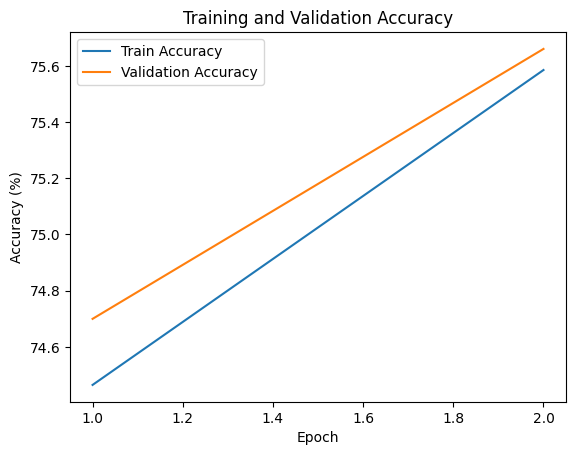

In [19]:
# Plot training and validation accuracy
epochs = range(1, n_epochs + 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## Evaluation

In [23]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt


In [24]:
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        labels = labels % 2  # Binary classification: even (0) vs odd (1)
        labels = labels.type(torch.float32).view(-1, 1)  # Reshape labels

        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = (outputs > 0.5).type(torch.float32)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(outputs.cpu().numpy())


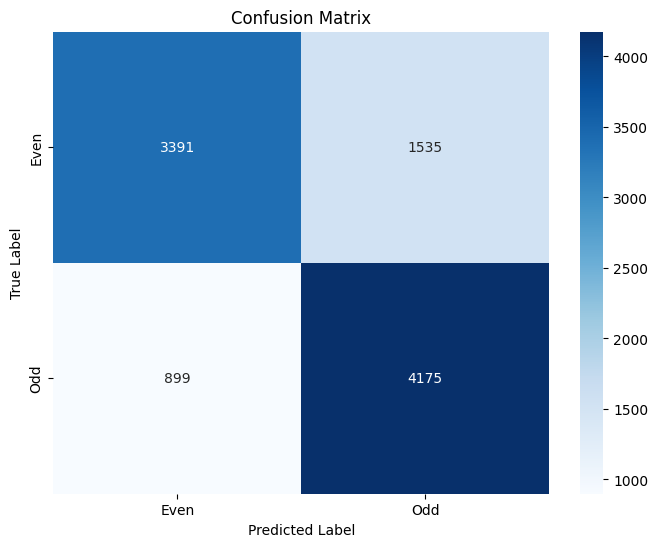

In [27]:
conf_matrix = confusion_matrix(all_labels, (np.array(all_predictions) > 0.5).astype(int))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Even", "Odd"], yticklabels=["Even", "Odd"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


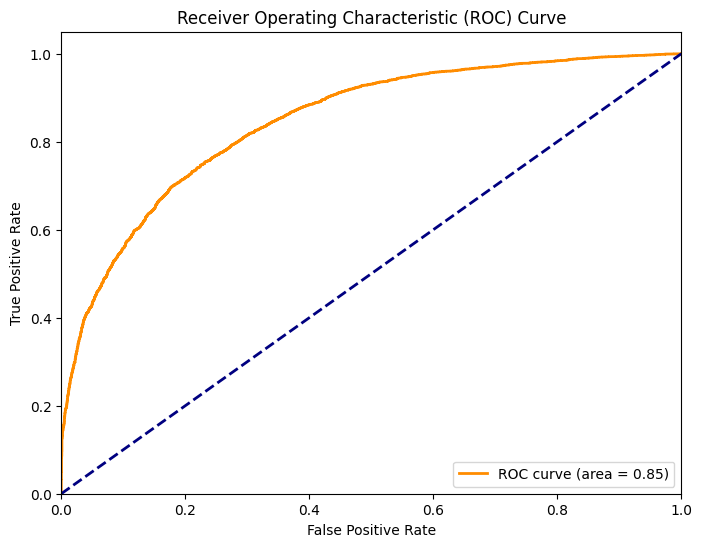

In [26]:
fpr, tpr, _ = roc_curve(all_labels, all_predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


In [33]:
torch.save(model.state_dict(),'../models/mnist_qnn_model_state.pth')